From UURAF Abstract:
Capture the subtle temporal dependencies within these signals that distinguish normal from abnormal rhythms.
This study explores the potential uses of machine learning and deep learning models to improve arrhythmia detection.
Moreover, it investigates how signal refinement, feature extraction, and frequency analyses affect a model’s ability to recognize meaningful variations in heart rhythms.
This investigation serves as a foundation for exploring future advancements in machine learning-based clinical decision support.
Be able to answer questions:
How did you choose the number of windows/spectograms per segment?
How did you choose the amount of overlap per window?
Why did you choose that ML architecture and preprocessing?
Create a new notebook that doesn’t have the noise exploration
Add in transformers as an option for the architecture
Consider other types of frequency analysis (1D Discrete Fourier Transforms)
Deliverable: 1 Dataframe with performance metrics comparing all models and all feature extractions


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import spectrogram

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, LayerNormalization, Dropout,
                                     MultiHeadAttention, GlobalAveragePooling1D,
                                     Add)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler


In [2]:
# =============== 1. Load and Preprocess ECG Data ===============

# Load ECG data
data = loadmat('ECGData.mat')
ecg_data = data['ECGData']
ecg_data_item = ecg_data[0, 0]

Signals = ecg_data_item['Data']  # shape: (162, 65536)
Labels_array = ecg_data_item['Labels']

# Convert labels to list of strings
Labels = [Labels_array[i, 0][0] for i in range(Labels_array.shape[0])]

# Map labels: NSR -> 0 (Normal), ARR/CHF -> 1 (Abnormal)
Labels_mapped = []
for label in Labels:
    if label == 'NSR':
        Labels_mapped.append(0)
    elif label in ['ARR', 'CHF']:
        Labels_mapped.append(1)
    else:
        # If there's anything else, label 2 (not used in binary classification),
        # but presumably there aren't extra labels in your dataset
        Labels_mapped.append(2)

Labels_mapped = np.array(Labels_mapped)

# Standardize signals
Signals_normalized = []
for signal in Signals:
    signal = signal.astype(np.float32)
    mean_val = np.mean(signal)
    std_val = np.std(signal) if np.std(signal) > 1e-6 else 1e-6
    signal = (signal - mean_val) / std_val
    Signals_normalized.append(signal)
Signals_normalized = np.array(Signals_normalized, dtype=np.float32)

print("Signals shape:", Signals_normalized.shape)
print("Labels shape:", Labels_mapped.shape)

# Optional: Quick distribution check
unique, counts = np.unique(Labels_mapped, return_counts=True)
print("Initial label distribution (0=Normal, 1=Abnormal, 2=Other?):")
for u,c in zip(unique, counts):
    print(f"  Label {u}: {c} samples")


Signals shape: (162, 65536)
Labels shape: (162,)
Initial label distribution (0=Normal, 1=Abnormal, 2=Other?):
  Label 0: 36 samples
  Label 1: 126 samples


In [3]:
# =============== 2. Segment the Data ===============
def segment_signals(signals, labels, sample_time_size=5, step_size=None, fs=128):
    """
    Segments ECG signals into smaller windows of length sample_time_size (sec).
    Returns segmented signals and corresponding labels.
    If step_size is None, uses non-overlapping windows of size sample_time_size.
    """
    window_size = fs * sample_time_size  # e.g., 5 sec * 128 Hz = 640 samples
    step_size = step_size or window_size # if None, no overlap

    segs, seg_labels = [], []
    for i in range(len(signals)):
        sig = signals[i]
        lbl = labels[i]
        if len(sig) < window_size:
            continue  # skip if the signal is too short

        for start in range(0, len(sig) - window_size + 1, step_size):
            segs.append(sig[start: start + window_size])
            seg_labels.append(lbl)

    return np.array(segs), np.array(seg_labels)

# Apply segmentation: 5-second windows, no overlap
X_segments, Y_segments = segment_signals(
    Signals_normalized, 
    Labels_mapped, 
    sample_time_size=5, 
    step_size=None,  # change if you want overlap
    fs=128
)

print("Segmented X shape:", X_segments.shape)  # (num_segments, time_steps=640)
print("Segmented Y shape:", Y_segments.shape)

# Encode labels after segmentation
le = LabelEncoder()
Y_segments_encoded = le.fit_transform(Y_segments)

# Optional distribution check after segmentation
unique_seg, counts_seg = np.unique(Y_segments_encoded, return_counts=True)
print("Segmented label distribution:")
for u,c in zip(unique_seg, counts_seg):
    print(f"  Label {u}: {c} segments")


Segmented X shape: (16524, 640)
Segmented Y shape: (16524,)
Segmented label distribution:
  Label 0: 3672 segments
  Label 1: 12852 segments


In [4]:
# =============== 3. Feature Extraction ===============
fs = 128

def compute_instantaneous_frequency_spectrogram(signal, fs):
    """Compute instantaneous frequency from spectrogram of the signal."""
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=64, noverlap=32)
    Sxx = np.abs(Sxx)
    Sxx_norm = Sxx / np.sum(Sxx, axis=0, keepdims=True)
    inst_freq = np.sum(f[:, np.newaxis] * Sxx_norm, axis=0)
    return inst_freq, t

def compute_spectral_entropy(signal, fs):
    """Compute spectral entropy from spectrogram of the signal."""
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=64, noverlap=32)
    Sxx = np.abs(Sxx)
    psd = Sxx / np.sum(Sxx, axis=0, keepdims=True)
    spectral_entropy = -np.sum(psd * np.log(psd + 1e-12), axis=0)
    spectral_entropy /= np.log(psd.shape[0])  # normalize by log of # freq bins
    return spectral_entropy, t

def extract_features_dataset(signals, fs):
    """Extracts [instantaneous frequency, spectral entropy] from each segment."""
    features = []
    for signal in signals:
        inst_freq, _ = compute_instantaneous_frequency_spectrogram(signal, fs)
        spectral_entropy, _ = compute_spectral_entropy(signal, fs)
        # Ensure same length
        min_len = min(len(inst_freq), len(spectral_entropy))
        inst_freq = inst_freq[:min_len]
        spectral_entropy = spectral_entropy[:min_len]
        # Stack them so shape = (2, time_steps_of_spectrogram)
        feat_matrix = np.vstack((inst_freq, spectral_entropy))
        features.append(feat_matrix)
    return features

X_features = extract_features_dataset(X_segments, fs)

# Zero-pad to the MAX length (instead of truncating to the MIN)
max_length = max(feat.shape[1] for feat in X_features)
X_features_padded = []
for feat in X_features:
    pad_width = max_length - feat.shape[1]
    if pad_width > 0:
        # Pad with zeros on the right (time dimension)
        feat_padded = np.pad(feat, ((0,0),(0,pad_width)), mode='constant')
    else:
        feat_padded = feat  # if already max_length, no padding needed
    X_features_padded.append(feat_padded)

# Convert to final shape (num_samples, time_steps, 2_features)
X_final = np.array([f.T for f in X_features_padded])  # shape: (samples, max_length, 2)

print("X_final shape:", X_final.shape)


X_final shape: (16524, 19, 2)


In [5]:
# =============== 4. Train-Test Split ===============
X_train, X_test, y_train, y_test = train_test_split(
    X_final, 
    Y_segments_encoded,
    test_size=0.2, 
    stratify=Y_segments_encoded, 
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=42
)

print("Train:", X_train.shape, "Labels:", y_train.shape)
print("Valid:", X_valid.shape, "Labels:", y_valid.shape)
print("Test:",  X_test.shape, "Labels:", y_test.shape)

# Optional distribution check
def print_label_distribution(dataset_name, y_data):
    unq, cnt = np.unique(y_data, return_counts=True)
    print(f"{dataset_name} distribution:")
    for u,c in zip(unq, cnt):
        print(f"  Label {u}: {c}")

print_label_distribution("Train", y_train)
print_label_distribution("Valid", y_valid)
print_label_distribution("Test", y_test)


Train: (10575, 19, 2) Labels: (10575,)
Valid: (2644, 19, 2) Labels: (2644,)
Test: (3305, 19, 2) Labels: (3305,)
Train distribution:
  Label 0: 2350
  Label 1: 8225
Valid distribution:
  Label 0: 588
  Label 1: 2056
Test distribution:
  Label 0: 734
  Label 1: 2571


In [6]:
# =============== 5. Define Transformer Model ===============

def positional_encoding(sequence_length, d_model):
    """Generates positional encoding for transformer input."""
    # shape: (sequence_length, 1)
    pos = np.arange(sequence_length)[:, np.newaxis]
    # shape: (d_model/2,)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pos_encoding = np.zeros((sequence_length, d_model))
    pos_encoding[:, 0::2] = np.sin(pos * div_term)
    pos_encoding[:, 1::2] = np.cos(pos * div_term)
    return tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    """
    Single Transformer Encoder Block:
      - Multi-head self-attention
      - Residual connection + LayerNorm
      - Feed-forward (Dense) network
      - Residual connection + LayerNorm
    Expected input shape: (batch_size, time_steps, d_model)
    """
    # Self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    x = Add()([attn_output, inputs])   # Residual
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward
    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(inputs.shape[-1])(ffn)  # project back to d_model
    x = Add()([ffn, x])  # Residual
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Model parameters
sequence_length = X_train.shape[1]  # max_length from the spectrogram
d_input = X_train.shape[2]         # 2 (the # of features: freq, entropy)
d_model = 64                       # embedding dimension
head_size = 64                     # key_dim in MultiHeadAttention
num_heads = 4
ff_dim = 128
dropout = 0.1
num_transformer_blocks = 2

inputs = Input(shape=(sequence_length, d_input))  # (None, seq_len, 2)

# 1) Map from 2 -> 64 dimension
x = Dense(d_model)(inputs)

# 2) Add positional encoding
pos_encoding = positional_encoding(sequence_length, d_model)
x = x + pos_encoding

# 3) Stacked Transformer Encoders
for _ in range(num_transformer_blocks):
    x = transformer_encoder(
        x, 
        head_size=head_size, 
        num_heads=num_heads, 
        ff_dim=ff_dim, 
        dropout=dropout
    )

# 4) Global Pool and Output
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Build and Compile
model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 19, 64)    │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 19, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 19, 64)    │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 19, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 19, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 19, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 19, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 19, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 19, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 19, 64)    │          0 │ dense_2[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 19, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 19, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 19, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 19, 64)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 19, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 19, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 19, 128)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 19, 64)    │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 19, 64)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ layer_normalizat

 Total params: 175,041 (683.75 KB)

 Trainable params: 175,041 (683.75 KB)

 Non-trainable params: 0 (0.00 B)

Original train distribution: [2350 8225]
Resampled distribution: [8225 8225]
Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6516 - loss: 0.6191 - val_accuracy: 0.6702 - val_loss: 0.5698
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7507 - loss: 0.5209 - val_accuracy: 0.7534 - val_loss: 0.4587
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7757 - loss: 0.4695 - val_accuracy: 0.7371 - val_loss: 0.4621
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7742 - loss: 0.4708 - val_accuracy: 0.7300 - val_loss: 0.4829
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7716 - loss: 0.4655 - val_accuracy: 0.7341 - val_loss: 0.4699
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7773 - loss: 0.4593 - val_accuracy: 0.7455 - val_loss: 0.4482
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7866 - loss: 0.4535 - val_accuracy: 0.7107 - val_loss: 0.5165
Epoch 8/50
258/258 ━

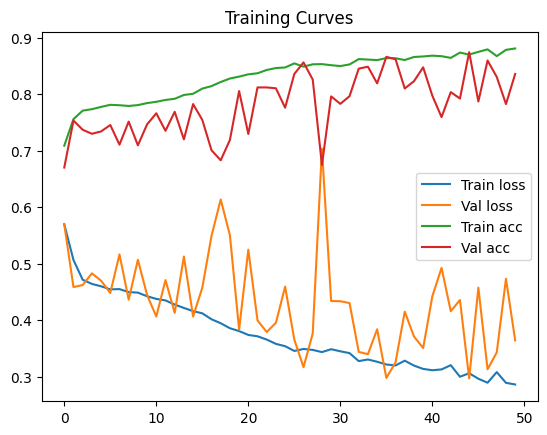

In [7]:
# =============== 6. Oversampling and Training ===============

# Random OverSampler to balance classes
ros = RandomOverSampler(random_state=42)

# Flatten the (seq_len, d_input) so oversampler can handle
n_train = X_train.shape[0]
seq_len = X_train.shape[1]
n_feats = X_train.shape[2]

X_train_2d = X_train.reshape(n_train, -1)  # shape: (n_train, seq_len*d_input)

X_resampled, y_resampled = ros.fit_resample(X_train_2d, y_train)
X_resampled = X_resampled.reshape(-1, seq_len, n_feats)

print("Original train distribution:", np.bincount(y_train))
print("Resampled distribution:", np.bincount(y_resampled))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_resampled, y_resampled,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training curves (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Training Curves")
plt.show()


In [8]:
# =============== 7. Evaluate Model ===============

# Predict on test set
y_pred_test_probs = model.predict(X_test)
y_pred_test = (y_pred_test_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test, digits=4)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Evaluate on training set (to check for overfitting)
print("\n---- Evaluate on Training Set ----")
y_pred_train_probs = model.predict(X_train)
y_pred_train = (y_pred_train_probs > 0.5).astype(int)
cm_train = confusion_matrix(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train, digits=4)
print("Train Confusion Matrix:")
print(cm_train)
print("Train Classification Report:")
print(report_train)


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix:
[[ 640   94]
 [ 299 2272]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6816    0.8719    0.7651       734
           1     0.9603    0.8837    0.9204      2571

    accuracy                         0.8811      3305
   macro avg     0.8209    0.8778    0.8427      3305
weighted avg     0.8984    0.8811    0.8859      3305


---- Evaluate on Training Set ----
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Train Confusion Matrix:
[[2092  258]
 [ 963 7262]]
Train Classification Report:
              precision    recall  f1-score   support

           0     0.6848    0.8902    0.7741      2350
           1     0.9657    0.8829    0.9225      8225

    accuracy                         0.8845     10575
   macro avg     0.8252    0.8866    0.8483     10575
weighted avg     0.9033    0.8845    0.8895     10575

